In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_excel("E://Flexible_proj_lab/broad_assets_weekly_rets.xlsx")
data

,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
0,2000-07-31,0.015154,0.075677,-0.002266,0.000897,0.042162,0.004952,0.037313,0.002093,-0.002477,-0.008385,-0.031787
1,2000-08-07,0.067870,0.052623,0.015929,0.013358,0.036514,-0.023689,-0.019612,-0.011556,0.024090,-0.026565,0.034584
2,2000-08-14,0.015698,0.002262,0.015185,0.006338,0.017116,0.025353,0.029392,0.036872,0.008525,0.006253,0.048137
3,2000-08-21,0.009488,0.056625,-0.001838,-0.000252,0.006775,-0.026410,0.001619,-0.002437,0.007701,0.001821,0.038370
4,2000-08-28,0.018391,0.065276,0.001894,0.004126,0.037931,-0.035294,0.019534,-0.017000,0.001856,-0.009469,0.031318
...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-08-12,0.060689,0.071826,-0.044042,-0.014738,0.020995,0.042517,0.043057,0.088217,0.009326,0.050343,0.058296
1254,2024-08-19,0.100581,0.134610,0.019896,-0.000441,0.103698,0.032142,0.093122,0.077077,-0.023833,0.023948,-0.037742
1255,2024-08-26,0.002016,-0.026628,0.002796,0.006442,0.045003,0.054048,0.029013,-0.017973,-0.019513,0.009670,0.033216
1256,2024-08-30,0.010834,0.005016,-0.030972,-0.009397,-0.000694,0.009146,0.012656,-0.005479,0.017512,-0.012593,-0.034825


For the MV optimization, I use 4 weeks as a lookback period, that is my expected return and history volatility are based on the data within four weeks

For the first four weeks, equally weighted the assets with positive returns

In [4]:
weight_matrix = [[0 for _ in range(data.shape[1]-1)] for _ in range(data.shape[0])]

In [5]:
for i in range(4):
    row = data.iloc[i,1:].values
    count = 0
    for j in range(11):
        if (row[j]>0):
            count+=1
            weight_matrix[i][j] = 1
    for j in range(11):
        if weight_matrix[i][j]==1:
            weight_matrix[i][j] = row[j]/count

After that, we do mean-variance optimization for assets in the following weeks

First try the optimization: max(portfolio_return-risk_aversion*portfolio_risk)

In [6]:
risk_aversion = 0.1

In [7]:
ind_dict = {f'Asset {i}':i-1 for i in range(1, 12)}

In [86]:
for i in range(4, data.shape[0]):
    weekly_returns = data.iloc[i,1:]
    positive_returns = weekly_returns[weekly_returns>0]
    target_matrix = data.loc[i-4:i-1, positive_returns.index]
    cov_matrix = target_matrix.cov().values
    mean_return = target_matrix.mean().values
    num_assets = len(mean_return)
    if (num_assets==0):
        continue
    # optimization
    def objective(weights):
        portfolio_return = np.dot(weights, mean_return)
        portfolio_risk = np.dot(weights.T, np.dot(cov_matrix, weights))
        return -(portfolio_return-risk_aversion*portfolio_risk)
    
    constrains = ({'type':'eq', 'fun': lambda weights: np.sum(weights)-1})
    bounds = tuple((0, 1) for _ in range(num_assets)) 
    initial_weights = num_assets*[1/num_assets]
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constrains)

    optimal_weight = result.x if result.success else np.zeros(num_assets)
    for j in range(len(optimal_weight)):
        asset = positive_returns.index[j]
        ind = ind_dict[asset]
        weight_matrix[i][ind] = optimal_weight[j]
        

In [87]:
weight_DataFrame = pd.DataFrame(weight_matrix, index=data['Date'], columns=[f'Asset {i}' for i in range(1, 12)])

In [88]:
weight_DataFrame

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,2.164838e-03,1.081098e-02,0.000000,1.282069e-04,0.006023,7.074257e-04,5.330466e-03,2.990370e-04,0.000000e+00,0.000000e+00,0.000000e+00
2000-08-07,9.695652e-03,7.517642e-03,0.002276,1.908247e-03,0.005216,0.000000e+00,0.000000e+00,0.000000e+00,3.441462e-03,0.000000e+00,4.940532e-03
2000-08-14,1.427091e-03,2.056743e-04,0.001380,5.761574e-04,0.001556,2.304846e-03,2.672025e-03,3.352042e-03,7.749756e-04,5.684937e-04,4.376094e-03
2000-08-21,1.355373e-03,8.089268e-03,0.000000,0.000000e+00,0.000968,0.000000e+00,2.313413e-04,0.000000e+00,1.100135e-03,2.601154e-04,5.481415e-03
2000-08-28,0.000000e+00,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,1.300763e-16,5.534070e-17,0.000000,0.000000e+00,0.000000,1.000000e+00,3.882316e-17,1.772385e-16,5.835757e-18,0.000000e+00,2.436609e-16
2024-08-19,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,1.595946e-16,0.000000e+00,0.000000e+00,0.000000e+00,4.065903e-16,0.000000e+00
2024-08-26,2.209056e-16,0.000000e+00,1.000000,7.356982e-17,0.000000,0.000000e+00,6.994868e-17,0.000000e+00,0.000000e+00,1.609823e-15,0.000000e+00


In this MV optimization, it seems that in each period, the weight of one asset will be approximately 1, while others are approximately 0

Second method of MV optimization, max mean, while control variance below a threshold

In [109]:
max_variance = 0.02

In [110]:
for i in range(4, data.shape[0]):
    weekly_returns = data.iloc[i, 1:]
    positive_returns = weekly_returns[weekly_returns>0]
    target_matrix = data.loc[i-4:i-1, positive_returns.index]
    covariance_matrix = target_matrix.cov().values
    mean_return = target_matrix.mean().values
    num_of_assets = len(mean_return)
    if (num_of_assets==0):
        continue
    # optimization
    def objective(weights):
        return -np.dot(weights, mean_return)
    def variance_constraint(weights):
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        return max_variance-portfolio_variance
    constrains = [{'type':'eq', 'fun':lambda weights: np.sum(weights)-1}, 
                  {'type':'ineq', 'fun': variance_constraint}]
    bounds = tuple((0,1) for _ in range(num_of_assets))
    initial_weights = num_of_assets*[1/num_of_assets]
    
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constrains)

    optimal_weight = result.x if result.success else np.zeros(num_assets)
    for j in range(len(optimal_weight)):
        asset = positive_returns.index[j]
        ind = ind_dict[asset]
        weight_matrix[i][ind] = optimal_weight[j]

In [111]:
weight_DataFrame = pd.DataFrame(weight_matrix, index=data['Date'], columns=[f'Asset {i}' for i in range(1, 12)])

In [112]:
weight_DataFrame

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,2.164838e-03,0.010811,0.000000,1.282069e-04,6.023125e-03,0.000707,0.005330,2.990370e-04,0.000000e+00,0.000000e+00,0.000000
2000-08-07,9.695652e-03,0.007518,0.002276,1.908247e-03,5.216302e-03,0.000000,0.000000,0.000000e+00,3.441462e-03,0.000000e+00,0.004941
2000-08-14,1.427091e-03,0.000206,0.001380,5.761574e-04,1.556020e-03,0.002305,0.002672,3.352042e-03,7.749756e-04,5.684937e-04,0.004376
2000-08-21,1.355373e-03,0.008089,0.000000,0.000000e+00,9.678276e-04,0.000000,0.000231,0.000000e+00,1.100135e-03,2.601154e-04,0.005481
2000-08-28,0.000000e+00,1.000000,0.000000,2.602085e-18,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000e+00,3.025496e-16,0.000000e+00,0.000000
2024-08-19,0.000000e+00,0.000000,1.000000,0.000000e+00,2.035796e-16,0.000000,0.000000,1.281325e-16,0.000000e+00,0.000000e+00,0.000000
2024-08-26,0.000000e+00,0.000000,1.000000,7.156519e-17,1.729015e-16,0.000000,0.000000,0.000000e+00,0.000000e+00,6.661338e-16,0.000000


MV optimization with regularized regression, Ridge regression

In [46]:
# 全局做, 对于每一周的数据根据前面所有周的数据得到volatility and expected return 
def ridge_MV_optimization(sigma, ridge_penalty, drop_negative=True):
    for i in range(4, data.shape[0]):
        if (drop_negative):
            weekly_returns = data.iloc[i, 1:]
            positive_returns = weekly_returns[weekly_returns>0]
            target_matrix = data.loc[0:i, positive_returns.index]
            # covariance_matrix = target_matrix.cov().values
        else:
            target_matrix = data.iloc[0:(i+1), 1:]
        covariance_matrix = target_matrix.cov().values
        mean_return = target_matrix.mean().values
        num_of_assets = len(mean_return)
        if (num_of_assets==0):
            continue
        # optimization
        def objective(weights):
            portfolio_return = np.dot(weights, mean_return)
            ridge_term = ridge_penalty*np.sum(weights**2)
            return -(portfolio_return-ridge_term)
        def variance_constraint(weights):
            portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
            return sigma-portfolio_variance
        constrains = [{'type':'eq', 'fun':lambda weights: np.sum(weights)-1}, 
                    {'type':'ineq', 'fun': variance_constraint}]
        bounds = tuple((0,1) for _ in range(num_of_assets))
        initial_weights = num_of_assets*[1/num_of_assets]
        
        result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constrains)
        optimal_weight = result.x if result.success else np.zeros(num_assets)
        if (drop_negative):
            for j in range(len(optimal_weight)):
                asset = positive_returns.index[j]
                ind = ind_dict[asset]
                weight_matrix[i][ind] = optimal_weight[j]
        else:
            for j in range(len(optimal_weight)):
                weight_matrix[i][j] = optimal_weight[j]

In [68]:
ridge_MV_optimization(sigma=0.02, ridge_penalty=0.01)

In [69]:
weight_DataFrame = pd.DataFrame(weight_matrix, index=data['Date'], columns=[f'Asset {i}' for i in range(1, 12)])

In [70]:
weight_DataFrame

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,2.164838e-03,0.010811,0.000000e+00,0.000128,0.006023,7.074257e-04,5.330466e-03,2.990370e-04,0.000000e+00,0.000000e+00,0.000000e+00
2000-08-07,9.695652e-03,0.007518,2.275620e-03,0.001908,0.005216,0.000000e+00,0.000000e+00,0.000000e+00,3.441462e-03,0.000000e+00,4.940532e-03
2000-08-14,1.427091e-03,0.000206,1.380416e-03,0.000576,0.001556,2.304846e-03,2.672025e-03,3.352042e-03,7.749756e-04,5.684937e-04,4.376094e-03
2000-08-21,1.355373e-03,0.008089,0.000000e+00,0.000000,0.000968,0.000000e+00,2.313413e-04,0.000000e+00,1.100135e-03,2.601154e-04,5.481415e-03
2000-08-28,7.514631e-17,1.000000,9.903432e-18,0.000000,0.000000,1.061272e-16,5.824365e-17,8.637018e-17,7.586327e-17,7.029111e-17,1.937672e-17
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,1.281769e-01,0.151824,5.921948e-02,0.047074,0.146842,1.311020e-01,8.371797e-02,1.275299e-01,0.000000e+00,1.532143e-01,7.759364e-02
2024-08-19,1.311085e-01,0.158525,6.003686e-02,0.046561,0.151803,1.316055e-01,8.181416e-02,1.294590e-01,2.428613e-17,1.556485e-01,6.688583e-02
2024-08-26,1.519844e-01,0.135882,8.100038e-02,0.065458,0.174373,1.545523e-01,1.038040e-01,1.132308e-01,1.387779e-17,1.768096e-01,9.201772e-02


In [71]:
weight_DataFrame = weight_DataFrame.iloc[0:-1, :] # we don't need the weights for the last week

In [76]:
weights = weight_DataFrame.values

In [ ]:
data1 = data.iloc[1:, :]
data1 = data1.set_index('Date')

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-08-07,0.067870,0.052623,0.015929,0.013358,0.036514,-0.023689,-0.019612,-0.011556,0.024090,-0.026565,0.034584
2000-08-14,0.015698,0.002262,0.015185,0.006338,0.017116,0.025353,0.029392,0.036872,0.008525,0.006253,0.048137
2000-08-21,0.009488,0.056625,-0.001838,-0.000252,0.006775,-0.026410,0.001619,-0.002437,0.007701,0.001821,0.038370
2000-08-28,0.018391,0.065276,0.001894,0.004126,0.037931,-0.035294,0.019534,-0.017000,0.001856,-0.009469,0.031318
2000-09-01,0.008391,0.072790,0.014815,0.015795,0.058842,-0.003190,0.029899,-0.009371,-0.000388,0.017777,0.032205
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.060689,0.071826,-0.044042,-0.014738,0.020995,0.042517,0.043057,0.088217,0.009326,0.050343,0.058296
2024-08-19,0.100581,0.134610,0.019896,-0.000441,0.103698,0.032142,0.093122,0.077077,-0.023833,0.023948,-0.037742
2024-08-26,0.002016,-0.026628,0.002796,0.006442,0.045003,0.054048,0.029013,-0.017973,-0.019513,0.009670,0.033216


In [77]:
week_returns = data1.values

In [79]:
portfolio_returns = np.sum(weights*week_returns, axis=1)

In [54]:
def calculate_cum_return(ret):
    res = []
    cum_sum = 1
    for i in range(len(ret)):
        cum_sum = cum_sum*(1+ret[i])
        res.append(cum_sum)
    return res

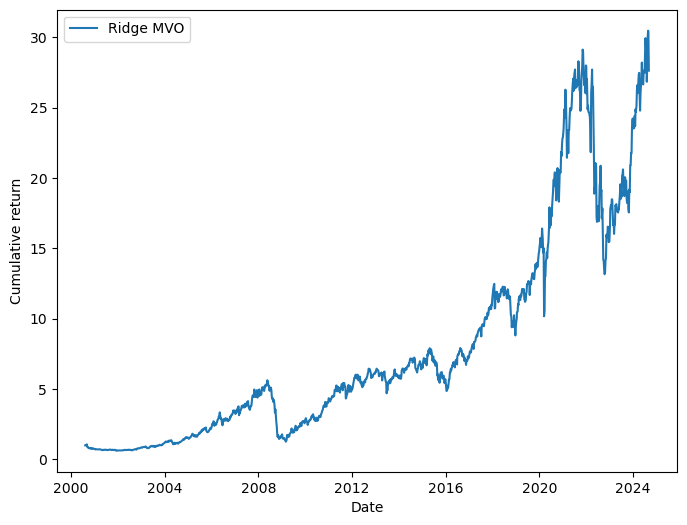

In [80]:
x = np.array(data1.index)
y = calculate_cum_return(portfolio_returns)
fig = plt.figure(figsize=(8,6))
plt.plot(x, y, label='Ridge MVO')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()

Next, I plot the cumulative return curve of the portfolio that I didn't drop negative returns in each week

In [56]:
ridge_MV_optimization(sigma=0.02, ridge_penalty=0.01, drop_negative=False)

In [57]:
weight_DataFrame = pd.DataFrame(weight_matrix, index=data['Date'], columns=[f'Asset {i}' for i in range(1, 12)])

In [60]:
weight_DataFrame = weight_DataFrame.iloc[0:-1, :] # we don't use the last row

In [ ]:
data1 = data1.iloc[1:, :]

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-08-07,0.067870,0.052623,0.015929,0.013358,0.036514,-0.023689,-0.019612,-0.011556,0.024090,-0.026565,0.034584
2000-08-14,0.015698,0.002262,0.015185,0.006338,0.017116,0.025353,0.029392,0.036872,0.008525,0.006253,0.048137
2000-08-21,0.009488,0.056625,-0.001838,-0.000252,0.006775,-0.026410,0.001619,-0.002437,0.007701,0.001821,0.038370
2000-08-28,0.018391,0.065276,0.001894,0.004126,0.037931,-0.035294,0.019534,-0.017000,0.001856,-0.009469,0.031318
2000-09-01,0.008391,0.072790,0.014815,0.015795,0.058842,-0.003190,0.029899,-0.009371,-0.000388,0.017777,0.032205
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.060689,0.071826,-0.044042,-0.014738,0.020995,0.042517,0.043057,0.088217,0.009326,0.050343,0.058296
2024-08-19,0.100581,0.134610,0.019896,-0.000441,0.103698,0.032142,0.093122,0.077077,-0.023833,0.023948,-0.037742
2024-08-26,0.002016,-0.026628,0.002796,0.006442,0.045003,0.054048,0.029013,-0.017973,-0.019513,0.009670,0.033216


In [63]:
weights = weight_DataFrame.values

In [64]:
week_returns = data1.values
portfolio_returns = np.sum(weights*week_returns, axis=1)

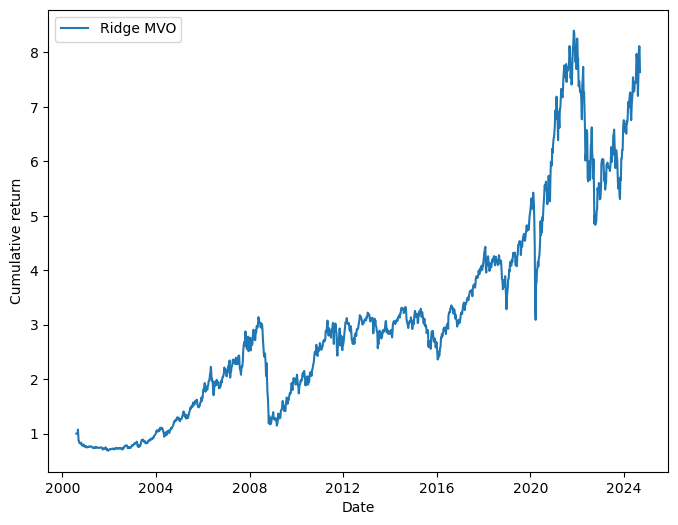

In [66]:
x = np.array(data1.index)
y = calculate_cum_return(portfolio_returns)
fig = plt.figure(figsize=(8,6))
plt.plot(x, y, label='Ridge MVO')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()

In MV optimization with ridge regression, the optimal weights in each period is not just a 1 with others 0, but the next problem is tune the parameters

MV optimization with regularized regression, Lasso Regression

In [130]:
def lasso_MV_optimization(sigma, lasso_penalty):
    for i in range(4, data.shape[0]):
        weekly_returns = data.iloc[i, 1:]
        positive_returns = weekly_returns[weekly_returns>0]
        target_matrix = data.loc[i-4:i-1, positive_returns.index]
        covariance_matrix = target_matrix.cov().values
        mean_return = target_matrix.mean().values
        num_of_assets = len(mean_return)
        if (num_of_assets==0):
            continue
        # optimization
        def objective(weights):
            portfolio_return = np.dot(weights, mean_return)
            lasso_term = lasso_penalty*np.sum(abs(weights))
            return -(portfolio_return-lasso_term)
        def variance_constraint(weights):
            portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
            return sigma-portfolio_variance
        constrains = [{'type':'eq', 'fun':lambda weights: np.sum(weights)-1}, 
                    {'type':'ineq', 'fun': variance_constraint}]
        bounds = tuple((0,1) for _ in range(num_of_assets))
        initial_weights = num_of_assets*[1/num_of_assets]
        
        result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constrains)
        optimal_weight = result.x if result.success else np.zeros(num_assets)
        for j in range(len(optimal_weight)):
            asset = positive_returns.index[j]
            ind = ind_dict[asset]
            weight_matrix[i][ind] = optimal_weight[j]

In [141]:
lasso_MV_optimization(sigma=0.02, lasso_penalty=0.01)

In [142]:
weight_DataFrame = pd.DataFrame(weight_matrix, index=data['Date'], columns=[f'Asset {i}' for i in range(1, 12)])

In [143]:
weight_DataFrame

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,2.164838e-03,1.081098e-02,0.000000e+00,1.282069e-04,6.023125e-03,7.074257e-04,5.330466e-03,0.000299,0.000000e+00,0.000000e+00,0.000000e+00
2000-08-07,9.695652e-03,7.517642e-03,2.275620e-03,1.908247e-03,5.216302e-03,0.000000e+00,0.000000e+00,0.000000,3.441462e-03,0.000000e+00,4.940532e-03
2000-08-14,1.427091e-03,2.056743e-04,1.380416e-03,5.761574e-04,1.556020e-03,2.304846e-03,2.672025e-03,0.003352,7.749756e-04,5.684937e-04,4.376094e-03
2000-08-21,1.355373e-03,8.089268e-03,0.000000e+00,0.000000e+00,9.678276e-04,0.000000e+00,2.313413e-04,0.000000,1.100135e-03,2.601154e-04,5.481415e-03
2000-08-28,7.355228e-16,1.000000e+00,3.252607e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,5.724587e-17
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.436759e-16,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2024-08-19,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.313569e-17,3.295975e-16,1.157195e-16,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2024-08-26,0.000000e+00,0.000000e+00,1.000000e+00,4.462994e-16,5.251688e-17,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.775558e-17,0.000000e+00


For MV optimization with Lasso regression, the optimal result also tends to be just one asset with weight 1, others are weight 0